<a href="https://colab.research.google.com/github/jungwoo1208/AI_Study/blob/main/mlptest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("device: ", device)

device:  cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
training_epochs=100
batch_size=64

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 평균/표준편차
])

# CIFAR-100 데이터셋 다운로드 및 적용
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# DataLoader: 배치로 묶기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

100%|██████████| 169M/169M [00:45<00:00, 3.74MB/s]


In [9]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(32*32*3,256))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(256,128))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(128,100))
print(model)

Sequential(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=100, bias=True)
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model.train()
model.to(device) # Move the model to the correct device
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0.0
    total_batches = len(train_loader)

    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        data = data.view(data.size(0), -1)  # (B, 3, 32, 32) → (B, 3072)

        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / total_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 3.7920
Epoch 2/100, Loss: 3.4091
Epoch 3/100, Loss: 3.2393
Epoch 4/100, Loss: 3.1205
Epoch 5/100, Loss: 3.0112
Epoch 6/100, Loss: 2.9167
Epoch 7/100, Loss: 2.8294
Epoch 8/100, Loss: 2.7423
Epoch 9/100, Loss: 2.6645
Epoch 10/100, Loss: 2.5936
Epoch 11/100, Loss: 2.5208
Epoch 12/100, Loss: 2.4552
Epoch 13/100, Loss: 2.3839
Epoch 14/100, Loss: 2.3202
Epoch 15/100, Loss: 2.2624
Epoch 16/100, Loss: 2.2060
Epoch 17/100, Loss: 2.1494
Epoch 18/100, Loss: 2.1065
Epoch 19/100, Loss: 2.0527
Epoch 20/100, Loss: 1.9975
Epoch 21/100, Loss: 1.9571
Epoch 22/100, Loss: 1.9223
Epoch 23/100, Loss: 1.8679
Epoch 24/100, Loss: 1.8423
Epoch 25/100, Loss: 1.8029
Epoch 26/100, Loss: 1.7648
Epoch 27/100, Loss: 1.7281
Epoch 28/100, Loss: 1.6961
Epoch 29/100, Loss: 1.6699
Epoch 30/100, Loss: 1.6339
Epoch 31/100, Loss: 1.6033
Epoch 32/100, Loss: 1.5850
Epoch 33/100, Loss: 1.5525
Epoch 34/100, Loss: 1.5138
Epoch 35/100, Loss: 1.4968
Epoch 36/100, Loss: 1.4794
Epoch 37/100, Loss: 1.4474
Epoch 38/1

KeyboardInterrupt: 

Accuracy of the batch: 20.31%


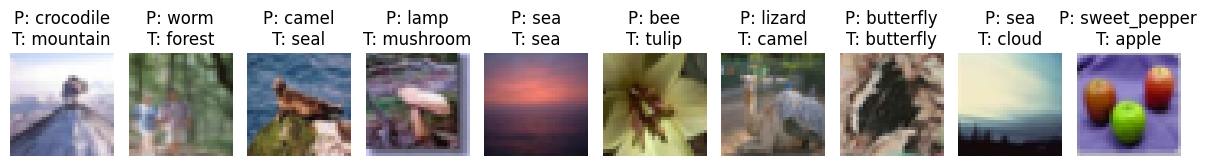

In [19]:
model.eval()

# 클래스 이름 불러오기 (CIFAR-100의 클래스 라벨)
classes = train_dataset.classes  # 예: ['apple', 'aquarium_fish', ...]

# 한 배치만 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지 reshape (batch, 3, 32, 32) → (batch, 3072)
X = images.view(-1, 3072).to(device)
Y = labels.to(device)

# 예측
with torch.no_grad():
    outputs = model(X)
    _, predicted = torch.max(outputs, 1)

# 정확도 계산
correct = (predicted == Y).sum().item()
total = Y.size(0)
accuracy = correct / total * 100
print(f'Accuracy of the batch: {accuracy:.2f}%')

# 이미지 보여주기용 함수
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)

    # 정규화 복원
    mean = np.array([0.5071, 0.4865, 0.4409])
    std = np.array([0.2673, 0.2564, 0.2762])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')

# 처음 5개 이미지 시각화 + 예측 결과
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(1, 10, i+1)
    imshow(images[i])
    plt.title(f'P: {classes[predicted[i]]}\nT: {classes[labels[i]]}')
plt.tight_layout()
plt.show()
